In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Load and preprocess data
df = pd.read_csv(r'C:\Users\NEUTRON\Desktop\Excelerate\DATA VISUALIZATION VIRUAL INTERNSHIP\Marketing Team Data.csv')

In [26]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Check for missing values
print("Missing values check:")
print(df.isnull().sum())

Missing values check:
campaign_id                                     0
campaign_name                                   0
audience                                        0
age                                             0
geography                                       0
reach                                           0
impressions                                     0
frequency                                       0
clicks                                          0
unique_clicks                                   0
unique_link_clicks_(ulc)                        0
click-through_rate_(ctr_in_%)                   0
unique_click-through_rate_(unique_ctr_in_%)     0
amount_spent_in_inr                             0
cost_per_click_(cpc)                            0
cost_per_result_(cpr)                           0
@dropdown                                      33
@dropdown.1                                    33
dtype: int64


In [27]:
# Clean numeric columns
numeric_cols = ['click-through_rate_(ctr_in_%)', 'cost_per_click_(cpc)', 
                'amount_spent_in_inr', 'cost_per_result_(cpr)']
for col in numeric_cols:
    df[col] = df[col].replace({'\\$': '', ',': ''}, regex=True).astype(float)

# Calculate metrics
df['cpc'] = df['amount_spent_in_inr'] / df['clicks'].replace(0, 1)
df['engagement_rate'] = (df['clicks'] / df['impressions']) * 100
df['cost_per_engagement'] = df['amount_spent_in_inr'] / (df['clicks'] + 1)

In [28]:
# Calculate dynamic thresholds based on data distribution
ctr_median = df['click-through_rate_(ctr_in_%)'].median()
cpc_75th = df['cpc'].quantile(0.75)
engagement_25th = df['engagement_rate'].quantile(0.25)

print(f"\nPerformance Benchmarks:")
print(f"Median CTR: {ctr_median:.2f}%")
print(f"75th percentile CPC: {cpc_75th:.2f}")
print(f"25th percentile Engagement Rate: {engagement_25th:.2f}%\n")


Performance Benchmarks:
Median CTR: 3.98%
75th percentile CPC: 5.49
25th percentile Engagement Rate: 2.59%



In [29]:
# Enhanced flagging system
df['performance_score'] = (
    (df['click-through_rate_(ctr_in_%)'] / ctr_median) *
    (engagement_25th / df['engagement_rate']) *
    (cpc_75th / df['cpc'])
)

df['discontinue_flag'] = (df['performance_score'] < 0.5).astype(int)

In [30]:
# Segment by audience and campaign
campaign_performance = df.groupby(['campaign_id', 'campaign_name']).agg(
    avg_ctr=('click-through_rate_(ctr_in_%)', 'mean'),
    avg_cpc=('cpc', 'mean'),
    avg_engagement=('engagement_rate', 'mean'),
    total_spend=('amount_spent_in_inr', 'sum'),
    audience=('audience', 'first'),  # Keep audience for reference
    geography=('geography', 'first')  # Keep geography for reference
).sort_values('avg_cpc', ascending=False)

In [31]:
# Get flagged campaigns with more details
flagged_campaigns = df[df['discontinue_flag'] == 1][[
    'campaign_id', 'campaign_name', 'audience', 'geography',
    'click-through_rate_(ctr_in_%)', 'engagement_rate', 'cpc',
    'amount_spent_in_inr', 'performance_score'
]].sort_values('campaign_id')  # Sort by campaign number

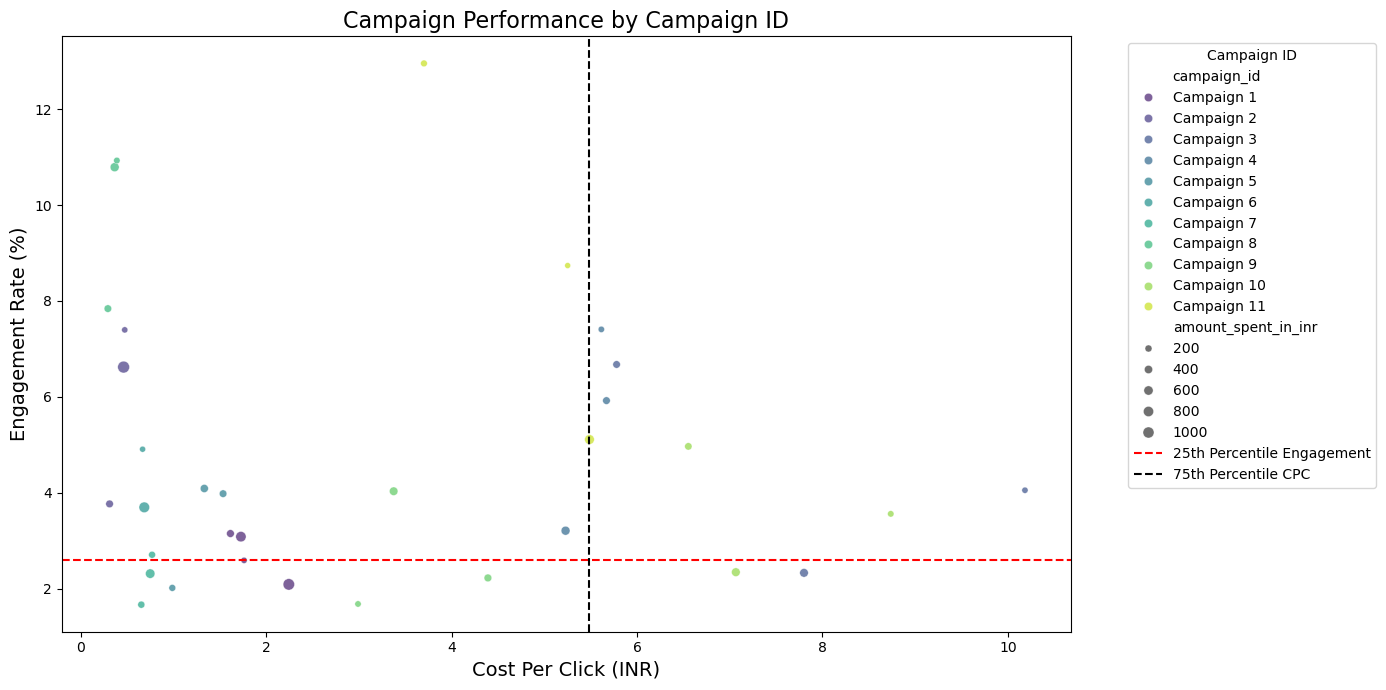

In [32]:
# Visualization
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df,
    x='cpc',
    y='engagement_rate',
    hue='campaign_id',  # Color by campaign ID
    size='amount_spent_in_inr',
    palette='viridis',  # Use a distinct color palette
    alpha=0.7
)
plt.axhline(y=engagement_25th, color='red', linestyle='--', label='25th Percentile Engagement')
plt.axvline(x=cpc_75th, color='black', linestyle='--', label='75th Percentile CPC')
plt.title('Campaign Performance by Campaign ID', fontsize=16)
plt.xlabel('Cost Per Click (INR)', fontsize=14)
plt.ylabel('Engagement Rate (%)', fontsize=14)
plt.legend(title='Campaign ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Prevent label cutoff
plt.savefig('campaign_performance_by_id.png', dpi=300)
plt.show()

In [33]:
# Display results
print("\nTop Underperforming Campaigns:")
print(flagged_campaigns.head(10).to_string(index=False))

print("\nPerformance by Audience and Geography:")
print(segmentation.to_string())


Top Underperforming Campaigns:
campaign_id           campaign_name audience geography  click-through_rate_(ctr_in_%)  engagement_rate       cpc  amount_spent_in_inr  performance_score
Campaign 10        SHU_Students(UK) Students        UK                           3.56         3.561644  8.736923               113.58           0.408861
 Campaign 3 SHU_Students(Australia) Students Australia                           2.33         2.331804  7.800820               475.85           0.457781
 Campaign 3 SHU_Students(Australia) Students Australia                           4.05         4.054054 10.184444                91.66           0.350560

Performance by Audience and Geography:
                                                                                                                                 avg_ctr   avg_cpc  avg_engagement  total_spend  count
audience                 geography                                                                                                   

In [48]:
import os

# Define output directory
output_path = r'C:\Users\NEUTRON\Desktop\Excelerate\Outputs'
os.makedirs(output_path, exist_ok=True)

# --------------------------------------------------
# 1. Save Enhanced Main DataFrame (with all metrics)
# --------------------------------------------------
df.to_csv(os.path.join(output_path, '1_enhanced_marketing_data.csv'), index=False)

# --------------------------------------------------
# 2. Save Flagged Campaigns (Sorted by Campaign ID)
# --------------------------------------------------
flagged_campaigns = df[df['discontinue_flag'] == 1][[
    'campaign_id', 'campaign_name', 
    'click-through_rate_(ctr_in_%)', 'engagement_rate', 'cpc',
    'amount_spent_in_inr', 'performance_score'
]].sort_values('campaign_id')  # Explicit sort by ID

flagged_campaigns.to_csv(os.path.join(output_path, '2_flagged_campaigns.csv'), index=False)

# --------------------------------------------------
# 3. Save Campaign Performance Analysis (ID-focused)
# --------------------------------------------------
campaign_performance = df.groupby('campaign_id').agg(
    campaign_name=('campaign_name', 'first'),
    avg_ctr=('click-through_rate_(ctr_in_%)', 'mean'),
    avg_cpc=('cpc', 'mean'),
    avg_engagement=('engagement_rate', 'mean'),
    total_spend=('amount_spent_in_inr', 'sum'),
    total_clicks=('clicks', 'sum')
).sort_values('campaign_id')  # Force ID-based sorting

campaign_performance.to_csv(os.path.join(output_path, '3_campaign_performance.csv'))

# --------------------------------------------------
# 4. Save Visualization (Campaign ID as Hue)
# --------------------------------------------------
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df,
    x='cpc',
    y='engagement_rate',
    hue='campaign_id',  # Campaign ID as primary differentiator
    size='amount_spent_in_inr',
    palette='tab20',  # Distinct colors for each campaign
    alpha=0.8,
    legend='full'
)

# Add benchmark lines
plt.axhline(y=engagement_25th, color='red', linestyle='--', label='25th Percentile Engagement')
plt.axvline(x=cpc_75th, color='black', linestyle='--', label='75th Percentile CPC')

# Formatting
plt.title('Campaign Performance by Campaign ID', fontsize=16)
plt.xlabel('Cost Per Click (INR)', fontsize=12)
plt.ylabel('Engagement Rate (%)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(output_path, '4_campaign_performance_plot.png'), dpi=300, bbox_inches='tight')
plt.close()

print("Outputs saved successfully in order:")
print(f"1. Enhanced data → {os.path.join(output_path, '1_enhanced_marketing_data.csv')}")
print(f"2. Flagged campaigns → {os.path.join(output_path, '2_flagged_campaigns.csv')}")
print(f"3. Performance report → {os.path.join(output_path, '3_campaign_performance.csv')}")
print(f"4. Visualization → {os.path.join(output_path, '4_campaign_performance_plot.png')}")

Outputs saved successfully in order:
1. Enhanced data → C:\Users\NEUTRON\Desktop\Excelerate\Outputs\1_enhanced_marketing_data.csv
2. Flagged campaigns → C:\Users\NEUTRON\Desktop\Excelerate\Outputs\2_flagged_campaigns.csv
3. Performance report → C:\Users\NEUTRON\Desktop\Excelerate\Outputs\3_campaign_performance.csv
4. Visualization → C:\Users\NEUTRON\Desktop\Excelerate\Outputs\4_campaign_performance_plot.png
